In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import calendar
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Load the cleaned dataset, parsing 'datetime' and setting it as the index
df = pd.read_csv(
    'D:/Data science/energy-forecasting-ml/data/processed/NESO_UK/cleaned_DemandData_2011-2018.csv',
    parse_dates=['datetime'],
    index_col='datetime'
)



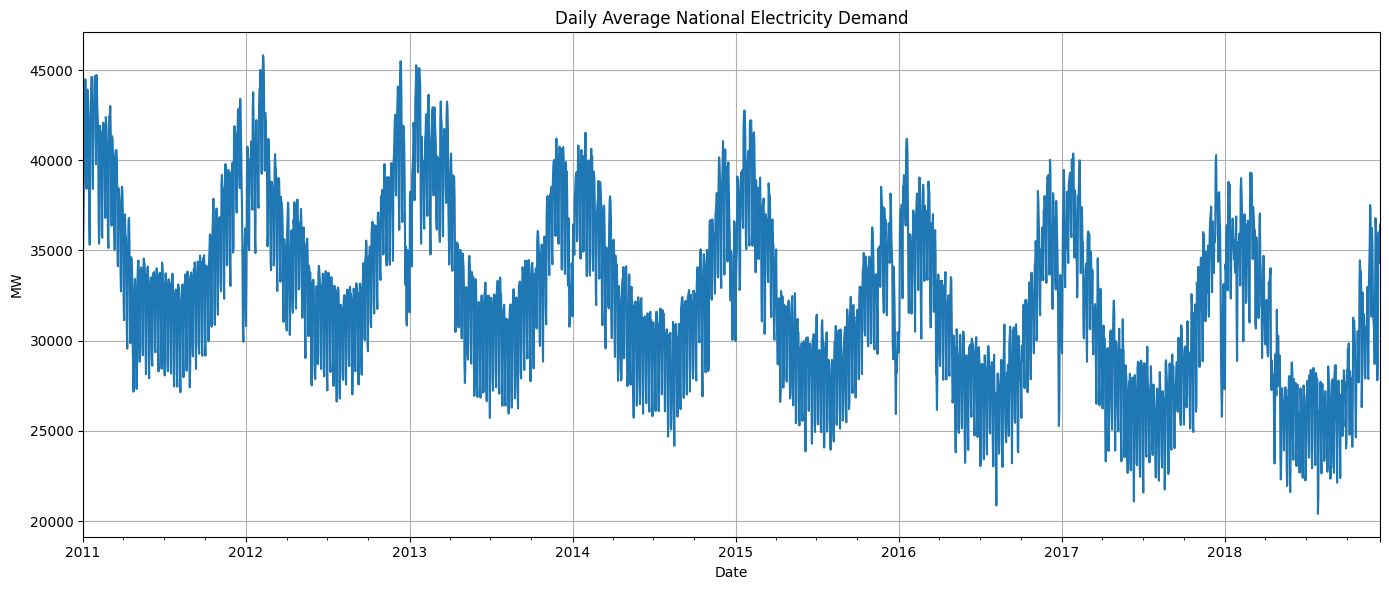

In [29]:
# Calculate the daily average national demand (ND)
# Resample to daily frequency and compute the mean for each day
daily_nd = df['I014_ND'].resample('D').mean()

# Create the plot
plt.figure(figsize=(14, 6))             # Set the figure size (width x height)
daily_nd.plot()                         # Plot the daily average ND

plt.title('Daily Average National Electricity Demand')  # Chart title
plt.xlabel('Date')                                      # X-axis label
plt.ylabel('MW')                                        # Y-axis label (megawatts)


plt.grid(True)                  # Show grid lines
plt.tight_layout()              # Adjust layout to prevent label overlap

# Display the graph
plt.show()

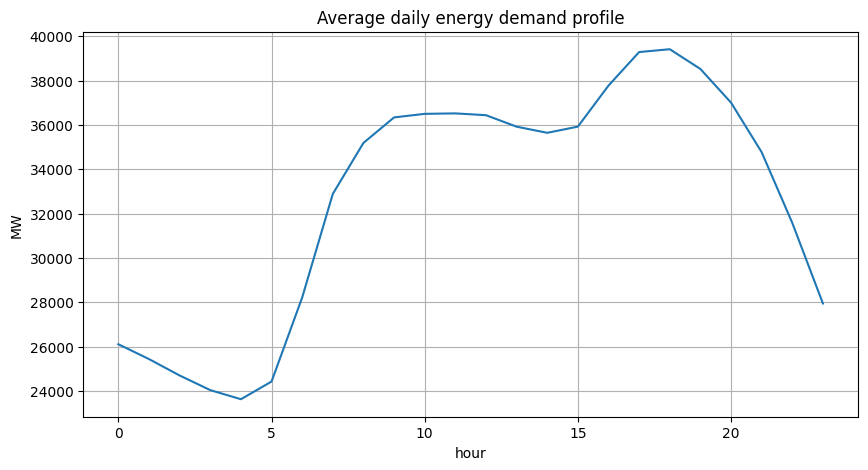

In [30]:

# Extract the hour of the day from the datetime index
df['hour'] = df.index.hour

# Group the data by hour (0 to 23) and calculate the average national demand (ND) for each hour
# This gives the average daily load profile across the entire dataset
df.groupby('hour')['I014_ND'].mean().plot(kind='line', title='Average daily energy demand profile', figsize=(10,5))
plt.ylabel('MW')
plt.grid(True)
plt.show()


<Figure size 1400x600 with 0 Axes>

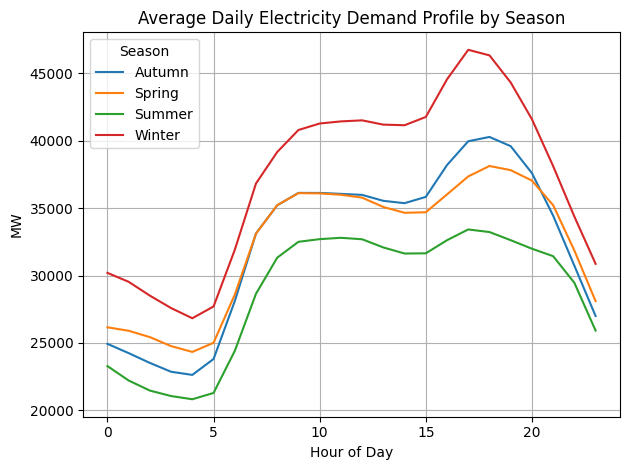

In [31]:



# Extract hour and month from datetime index
df['hour'] = df.index.hour
df['month'] = df.index.month

# Manually define the seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to assign a season to each row
df['season'] = df['month'].apply(get_season)

# Compute average electricity demand (ND) by hour and season
# Group by both 'season' and 'hour', then take the mean
grouped = df.groupby(['season', 'hour'])['I014_ND'].mean().reset_index()

# Reshape the result into a pivot table for easy plotting
# Rows: hours of the day, Columns: seasons, Values: average ND
seasonal_profile = grouped.pivot(index='hour', columns='season', values='I014_ND')


# Plot the seasonal load profiles
plt.figure(figsize=(14, 6))
seasonal_profile.plot()
plt.title('Average Daily Electricity Demand Profile by Season')
plt.xlabel('Hour of Day')
plt.ylabel('MW')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Season')
plt.show()


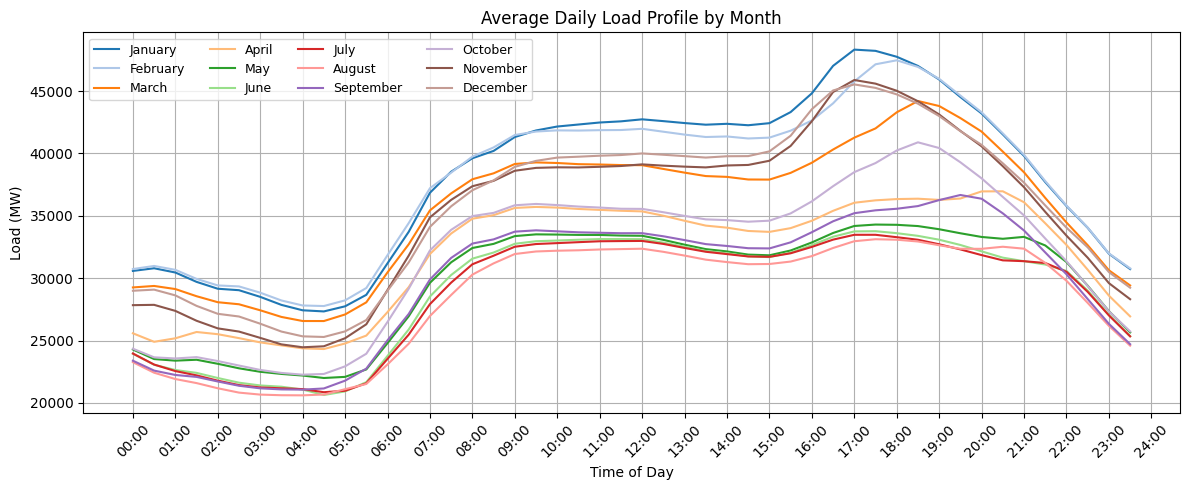

In [32]:
# Use a larger colormap (tab20 has 20 distinct colors)
colors = plt.get_cmap('tab20').colors

# Average daily profile for each month 
plt.figure(figsize=(12, 5))

# Loop through all 12 months
for month in range(1, 13):
    # Filter data for the current month
    month_data = df[df.index.month == month]

    # Compute average load profile per time of day (e.g., 00:00, 00:30, ..., 23:30)
    daily_profile = month_data.groupby(month_data.index.time)['I014_ND'].mean()

    # Convert times (datetime.time) to minutes since midnight for plotting
    times_as_minutes = [t.hour * 60 + t.minute for t in daily_profile.index]

    # Plot with the full English month name as label
    plt.plot(times_as_minutes, daily_profile.values,
             label=calendar.month_name[month],
             color=colors[month - 1])  # 0-indexed

# Customize plot
plt.title('Average Daily Load Profile by Month')
plt.xlabel('Time of Day')
plt.ylabel('Load (MW)')
plt.grid(True)

# Set x-ticks to display every hour
ticks = list(range(0, 24 * 60 + 1, 60))
labels = [f'{h:02}:00' for h in range(25)]
plt.xticks(ticks, labels, rotation=45)

# Show legend with month names
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.show()

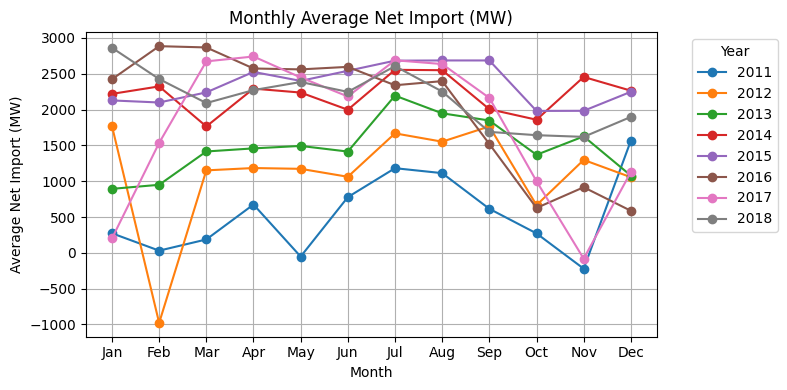

In [33]:
# Calculate 'net_import' as the sum of import flows from four interconnectors
df['net_import'] = df[
    ['I014_FRENCH_FLOW', 'I014_BRITNED_FLOW', 'I014_MOYLE_FLOW', 'I014_EAST_WEST_FLOW']
].sum(axis=1)

# Extract the year and month from the datetime index for grouping
df['year'] = df.index.year
df['month'] = df.index.month

# Group by year and month, then compute the average 'net_import' for each group
monthly_net = (
    df.groupby(['year', 'month'])['net_import']
    .mean()
    .reset_index()
)

# Define a list of month abbreviations for the x-axis labels
months_labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]

# Pivot the table so that each row is a month (1–12) and each column is a year
pivot_net = monthly_net.pivot(
    index='month',
    columns='year',
    values='net_import'
)

# Create a figure with a specified size
plt.figure(figsize=(8, 4))

# Plot one line per year, with markers at each month
for year in pivot_net.columns:
    plt.plot(
        pivot_net.index,
        pivot_net[year],
        marker='o',
        label=str(year)
    )

# Set the title and axis labels
plt.title('Monthly Average Net Import (MW)')
plt.xlabel('Month')
plt.ylabel('Average Net Import (MW)')

# Replace numeric month ticks (1–12) with their three-letter abbreviations
plt.xticks(ticks=range(1, 13), labels=months_labels)

# Add a legend to the plot
plt.legend(title='Year', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


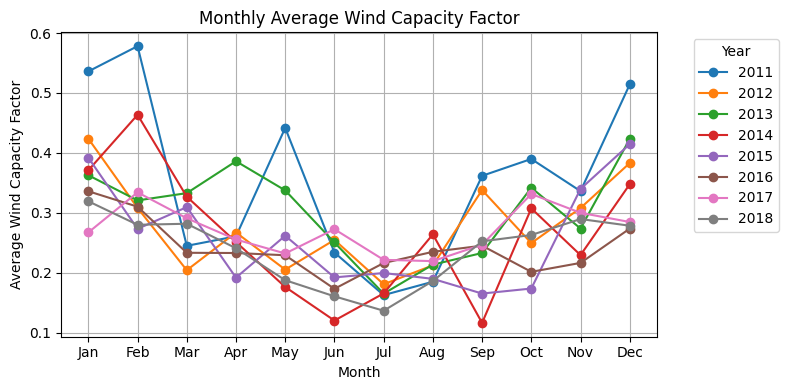

In [34]:

# Calculate Solar capacity factor 
df['wind_capacity_factor'] = df['EMBEDDED_WIND_GENERATION'] / df['EMBEDDED_WIND_CAPACITY']

# Group by year and month, then compute the average wind capacity factor for each group
monthly_wind_cf = (
    df.groupby(['year', 'month'])['wind_capacity_factor']
    .mean()
    .reset_index()
)

# Pivot the table so that each row corresponds to a month (1–12) and each column corresponds to a year
pivot_wind_cf = monthly_wind_cf.pivot(
    index='month',
    columns='year',
    values='wind_capacity_factor'
)

# Create a figure for the plot with the specified size
plt.figure(figsize=(8, 4))

# Plot one line per year, with markers at each month
for year in pivot_wind_cf.columns:
    plt.plot(
        pivot_wind_cf.index,
        pivot_wind_cf[year],
        marker='o',
        label=str(year)
    )

# Set the title and axis labels 
plt.title('Monthly Average Wind Capacity Factor')
plt.xlabel('Month')
plt.ylabel('Average Wind Capacity Factor')

# Replace numeric month ticks (1–12) with their three-letter abbreviations
plt.xticks(ticks=range(1, 13), labels=months_labels)

# Add a legend titled 'Year' 
plt.legend(title='Year', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

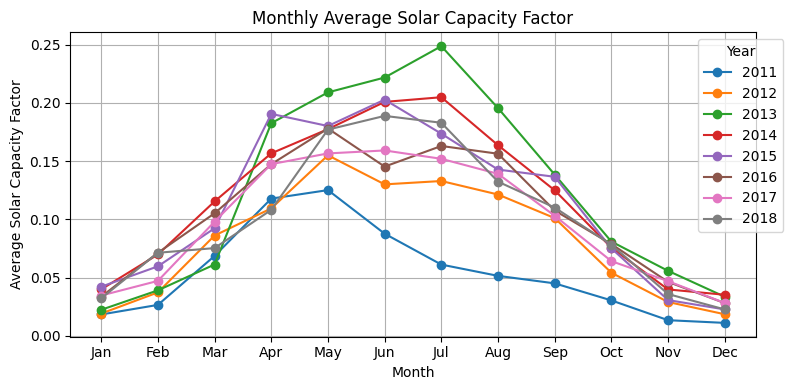

In [35]:
# Calculate the solar capacity factor
df['solar_capacity_factor'] = df['EMBEDDED_SOLAR_GENERATION'] / df['EMBEDDED_SOLAR_CAPACITY']

# Group by year and month, then compute the average solar capacity factor for each group
monthly_solar_cf = (
    df.groupby(['year', 'month'])['solar_capacity_factor']
    .mean()
    .reset_index()
)

# Pivot the table so that each row is a month (1–12) and each column is a year
pivot_solar_cf = monthly_solar_cf.pivot(
    index='month',
    columns='year',
    values='solar_capacity_factor'
)

# Create a figure with a specified size
plt.figure(figsize=(8, 4))

# Plot one line per year, with markers at each month
for year in pivot_solar_cf.columns:
    plt.plot(
        pivot_solar_cf.index,
        pivot_solar_cf[year],
        marker='o',
        label=str(year)
    )

# Set the title and axis labels in English
plt.title('Monthly Average Solar Capacity Factor')
plt.xlabel('Month')
plt.ylabel('Average Solar Capacity Factor')

# Replace numeric month ticks (1–12) with their three-letter abbreviations
plt.xticks(ticks=range(1, 13), labels=months_labels)

# Add a legend titled 'Year' 
plt.legend(title='Year', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

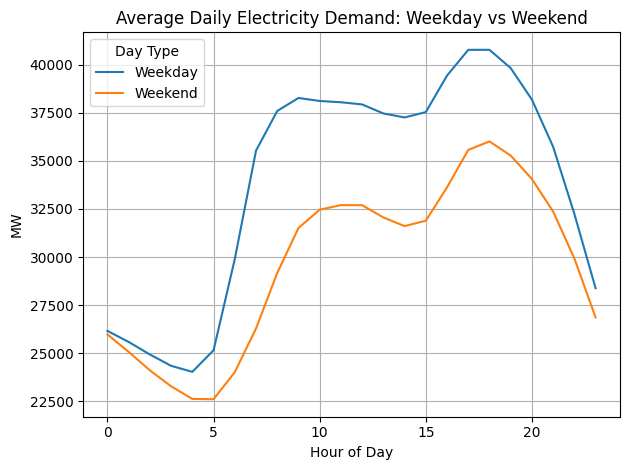

In [36]:
# Extract hour and weekday from the datetime index
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday  # 0 = Monday, ..., 6 = Sunday

# Create a new column classifying each row as 'Weekday' or 'Weekend'
df['week_type'] = df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate the average national demand (ND) per hour for weekdays and weekends
# Group by both week_type and hour, then compute the mean
grouped = df.groupby(['week_type', 'hour'])['I014_ND'].mean().reset_index()

# Pivot the grouped data: rows = hours, columns = week types, values = average ND
profile_week = grouped.pivot(index='hour', columns='week_type', values='I014_ND')


# Plot the hourly demand profile for weekdays vs. weekends
plt.figure(figsize=(12, 6))
profile_week.plot()
plt.title('Average Daily Electricity Demand: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('MW')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Day Type')
plt.show()

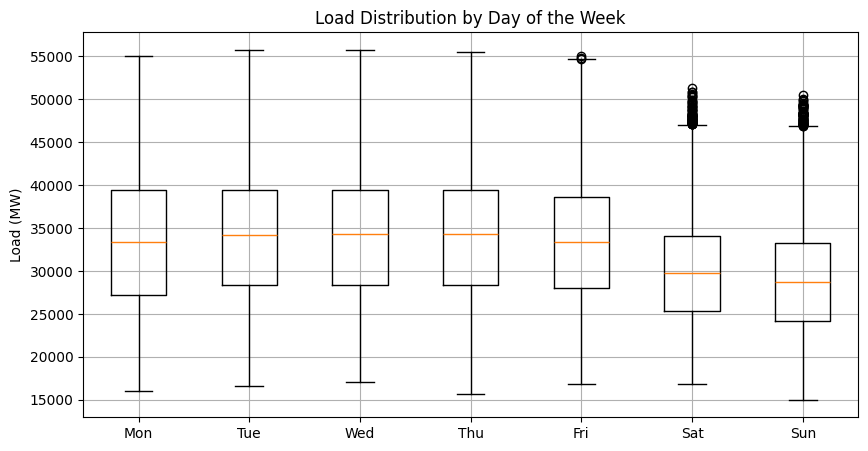

In [37]:
# Box plot of load distribution by day of the week ===

plt.figure(figsize=(10, 5))

# Create a list of load values grouped by weekday (0 = Monday, 6 = Sunday)
weekday_data = [df[df.index.weekday == i]['I014_ND'].values for i in range(7)]

# Create the box plot and label each box with the weekday name
plt.boxplot(weekday_data, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Add plot title and y-axis label
plt.title('Load Distribution by Day of the Week')
plt.ylabel('Load (MW)')
plt.grid(True)

# Display the plot
plt.show()

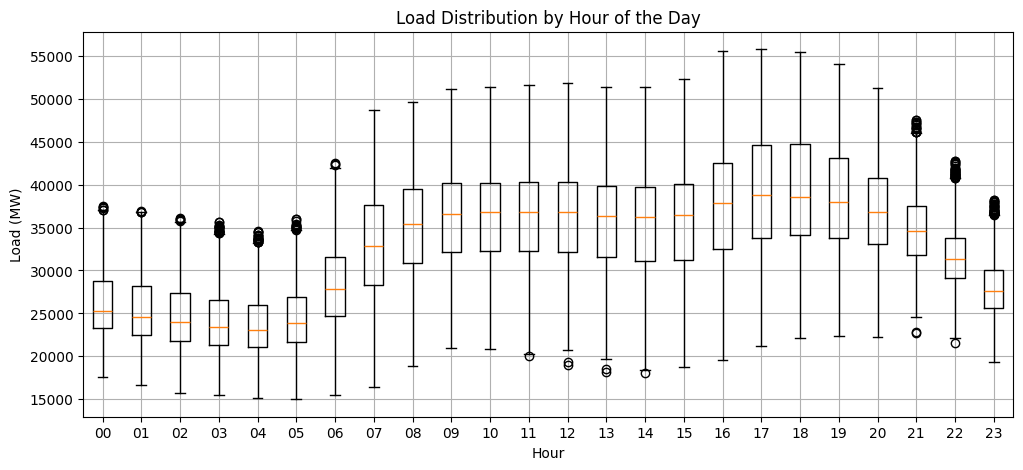

In [38]:
# Box plot of load distribution by hour of the day


plt.figure(figsize=(12, 5))

# Create a list of load values grouped by each hour (0 to 23)
hour_data = [df[df.index.hour == h]['I014_ND'].values for h in range(24)]

# Create the box plot, labeling each hour on the x-axis (formatted as '00', '01', ..., '23')
plt.boxplot(hour_data, labels=[f'{h:02}' for h in range(24)])

# Add plot title and axis labels
plt.title('Load Distribution by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.grid(True)

plt.show()

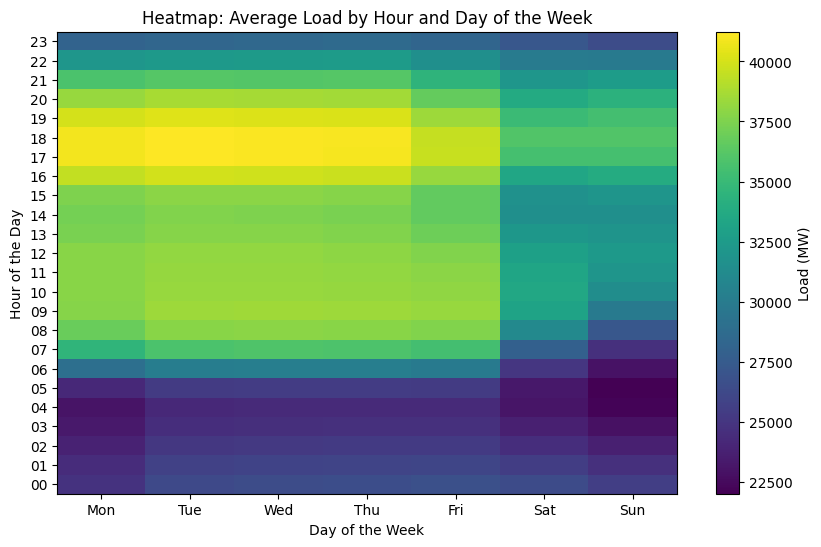

In [39]:
# Heatmap of average load by hour and weekday

# Create a pivot table: average load for each hour (rows) and weekday (columns)
pivot = df.groupby([df.index.hour, df.index.weekday])['I014_ND'].mean().unstack()

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the heatmap with hour on y-axis and weekday on x-axis
plt.imshow(pivot, aspect='auto', origin='lower')

# Add color bar to indicate load intensity
plt.colorbar(label='Load (MW)')

# Label x-axis with weekday names
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Label y-axis with hour numbers (formatted as '00' to '23')
plt.yticks(ticks=range(24), labels=[f'{h:02}' for h in range(24)])

# Add title and axis labels
plt.title('Heatmap: Average Load by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')


# Show the plot
plt.show()

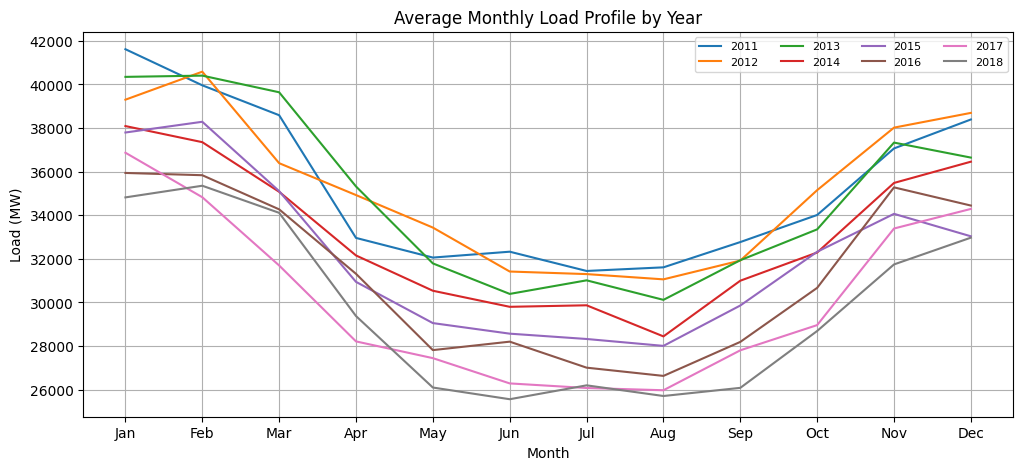

In [40]:
# Monthly average load profile for each year 


plt.figure(figsize=(12, 5))

# Loop through each year present in the data
for year in df.index.year.unique():
    # Filter data for the current year and select the target column
    yearly_data = df[df.index.year == year]['I014_ND']

    # Resample the data to monthly frequency and compute the monthly average
    monthly_profile = yearly_data.resample('ME').mean()

    # Plot the monthly profile using the month number (1–12) as x-axis
    plt.plot(monthly_profile.index.month, monthly_profile.values, label=str(year))

# Add plot title and axis labels
plt.title('Average Monthly Load Profile by Year')
plt.xlabel('Month')
plt.ylabel('Load (MW)')


month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set x-axis ticks to show months 1 through 12
plt.xticks(range(1, 13), month_labels)


# Add a legend
plt.legend(ncol=4, fontsize=8)


plt.grid(True)

# Display the plot
plt.show()

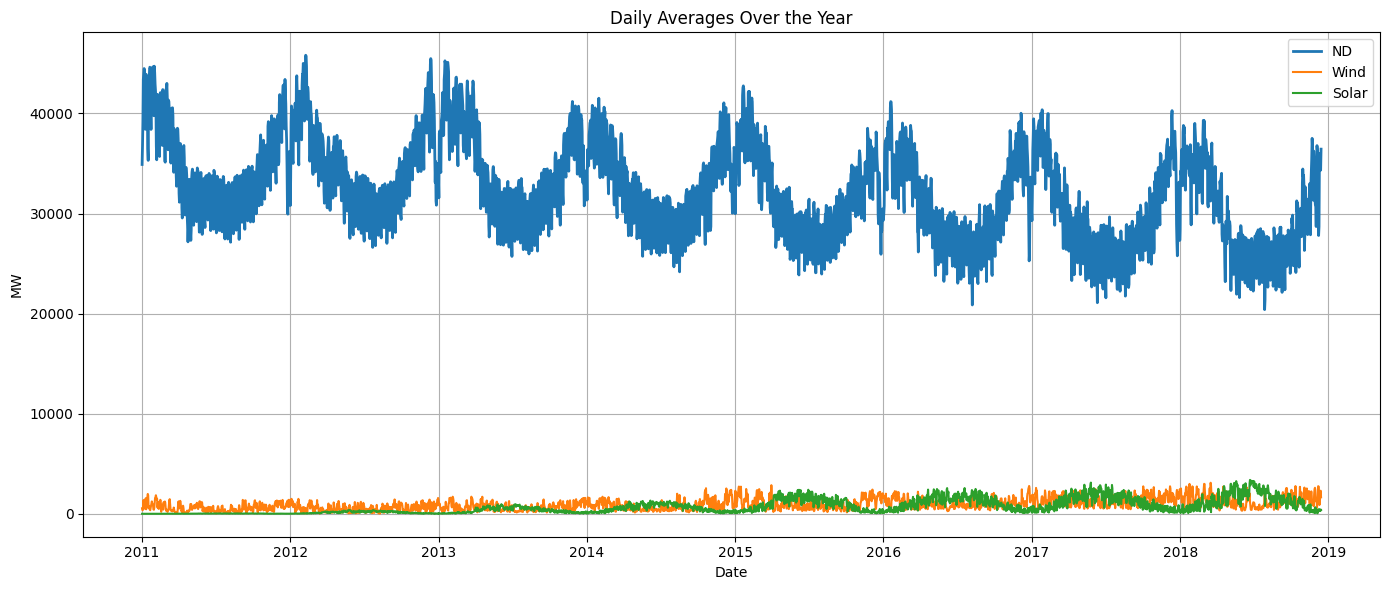

In [41]:

# We compute the daily average (mean) of three key variables:
# - ND: National Demand
# - EMBEDDED_WIND_GENERATION: Wind generation embedded in the grid
# - EMBEDDED_SOLAR_GENERATION: Solar generation embedded in the grid
daily = df.resample('D')[['I014_ND', 'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION']].mean()


plt.figure(figsize=(14, 6)) 

# Plot National Demand with a thicker line for emphasis
plt.plot(daily.index, daily['I014_ND'], label='ND', linewidth=2)

# Plot embedded wind and solar generation
plt.plot(daily.index, daily['EMBEDDED_WIND_GENERATION'], label='Wind')
plt.plot(daily.index, daily['EMBEDDED_SOLAR_GENERATION'], label='Solar')

# Add plot title and axis labels 
plt.title('Daily Averages Over the Year')   # Title for the whole plot
plt.xlabel('Date')                          # X-axis label (time)
plt.ylabel('MW')                            # Y-axis label (power in megawatts)
plt.legend()                                
plt.grid(True)                              


plt.tight_layout()                          
plt.show()                                  



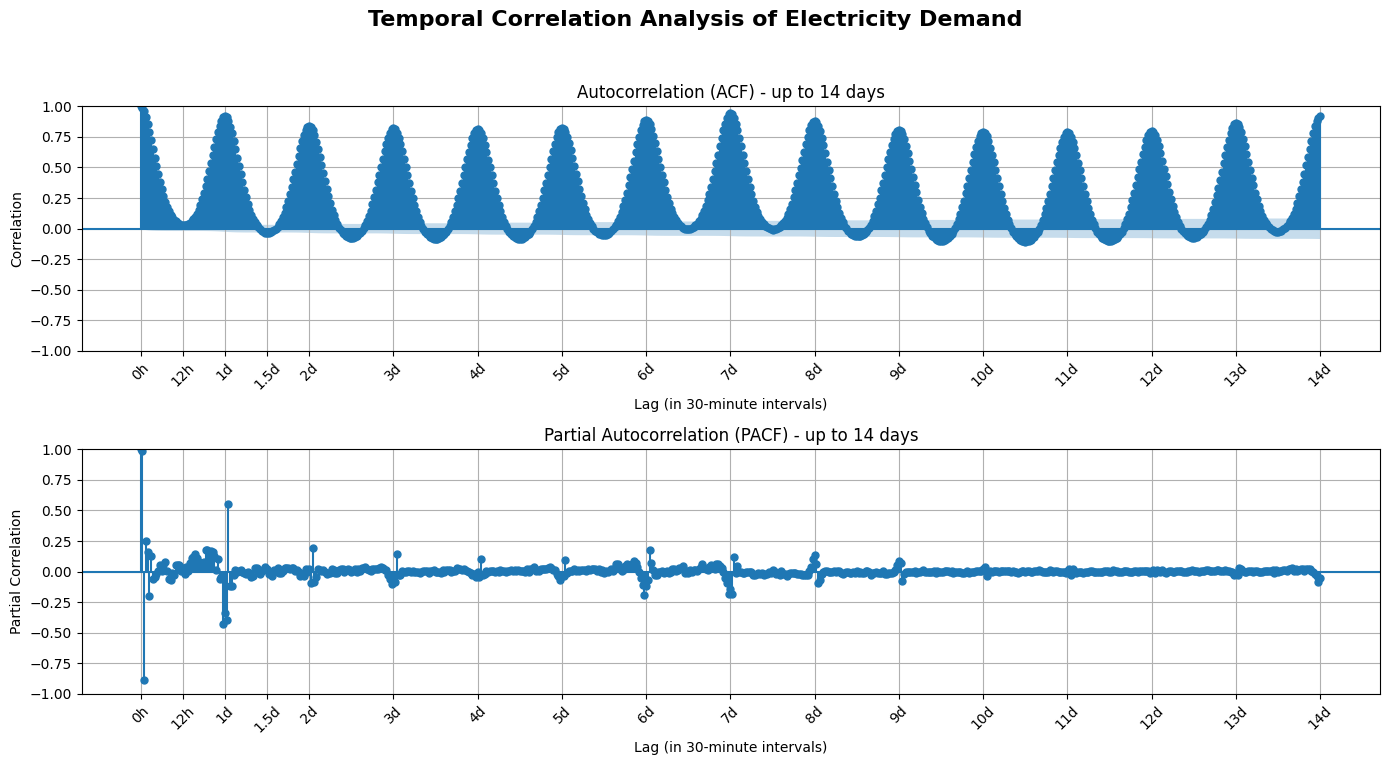

In [42]:
# Set up the figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=100)

# Number of lags (48 lags per day × 14 days)
max_lag = 48 * 14
x_ticks = [0, 24, 48, 72, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528, 576, 624, 672]
x_labels = ['0h', '12h', '1d', '1.5d', '2d', '3d', '4d', '5d', '6d', '7d', 
            '8d', '9d', '10d', '11d', '12d', '13d', '14d']

# ACF
plot_acf(df['I014_ND'],
         lags=max_lag,  # Number of lags to display (14 days)
         ax=axes[0],
         alpha=0.05)    # 95% confidence interval


axes[0].set_title('Autocorrelation (ACF) - up to 14 days')
axes[0].set_xlabel('Lag (in 30-minute intervals)')
axes[0].set_ylabel('Correlation')
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_labels, rotation=45)
axes[0].grid(True)


# PACF
plot_pacf(df['I014_ND'],
          lags=max_lag, # Number of lags to display (14 days)
          ax=axes[1],
          alpha=0.05)   # 95% confidence interval 


axes[1].set_title('Partial Autocorrelation (PACF) - up to 14 days')
axes[1].set_xlabel('Lag (in 30-minute intervals)')
axes[1].set_ylabel('Partial Correlation')
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_labels, rotation=45)
axes[1].grid(True)

# Global title
plt.suptitle('Temporal Correlation Analysis of Electricity Demand', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

